# Physics-informed

This example demonstrates the training of a physics-informed neural operator.

In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from continuity.operators import DeepONet
from continuity.pde import Grad, PhysicsInformedLoss
from continuity.data import OperatorDataset

In [2]:
torch.manual_seed(0)
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)
plt.rcParams["legend.framealpha"] = 0.0


## Problem Statement

Let's assume we want to learn the integration operator $G: u \mapsto \int u~dx$.
We choose a set of polynomials as input functions $u$.

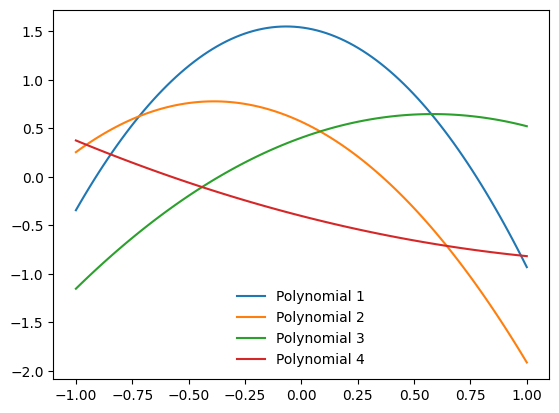

In [3]:
# Input functions are polynomials
degree = 2
def polynomial(coefficients):
    return lambda x: sum(
        coefficients[i] * x ** i
        for i in range(degree+1)
    )

def integral(coefficients):
    return lambda x: sum(
        coefficients[i] / (i+1) * x ** (i+1)
        for i in range(degree+1)
    )

# Generate coefficients
num_functions = 4
a = torch.randn(num_functions, degree+1)

# Plot functions
x = torch.linspace(-1, 1, 100)
for i in range(num_functions):
    u = polynomial(a[i])
    plt.plot(x, u(x), label=f"Polynomial {i+1}")
plt.legend()
plt.show()

## Data set
We define the data set as a list of input functions and evaluation coordinates, but without labels.

In [4]:
x = (torch.rand(32) * 2 - 1)  # Random sensor positions
x.requires_grad = True
y = x

data = []
u = torch.empty((num_functions, len(x), 1))
for i in range(num_functions):
    pol = polynomial(a[i])
    u[i, :] = pol(x).unsqueeze(1)

dataset = OperatorDataset(
    x=torch.outer(torch.ones(num_functions), x).unsqueeze(2),
    u=u,
    y=torch.outer(torch.ones(num_functions), y).unsqueeze(2),
    v=torch.outer(torch.ones(num_functions), torch.zeros_like(y)).unsqueeze(2)  # dummy, label won't be used
)
data_loader = DataLoader(dataset, batch_size=4)
print(f"The dataset contains {len(dataset)} different observations. The shape of the observations is: {dataset.shapes}.")

The dataset contains 4 different observations. The shape of the observations is: DatasetShapes(num_observations=4, x=TensorShape(num=32, dim=1), u=TensorShape(num=32, dim=1), y=TensorShape(num=32, dim=1), v=TensorShape(num=32, dim=1)).


## Neural Operator

In this example, we use a DeepONet architecture with 32 sensors (inferred from the dataset).

In [5]:
# Define operator
operator = DeepONet(shapes=dataset.shapes)

## Physics-informed loss

As we want to learn the intergral operator $G$, we define a physics-informed loss function: $v = \int u~dx \Rightarrow \partial_x v = u$.

In [6]:
# Derivative
grad = Grad()
mse = torch.nn.MSELoss()

def pde(_, u, y, v):
    v_y = grad(y, v)
    return mse(v_y, u)

loss_fn = PhysicsInformedLoss(pde)

## Training

We train the neural operator using the physics-informed loss function. 

In [7]:
optimizer = torch.optim.Adam(operator.parameters(), lr=1e-3)

operator.compile(optimizer, loss_fn)
operator.fit(data_loader, epochs=1000)

Model parameters: 7984
Epoch 1000:  loss/train = 3.2787e-05  (0.00 s/epoch)


## Evaluating the trained operator

The trained operator can be evaluated at arbitrary positions, so let's plot a
fine resolution of the mapping along with the target function.

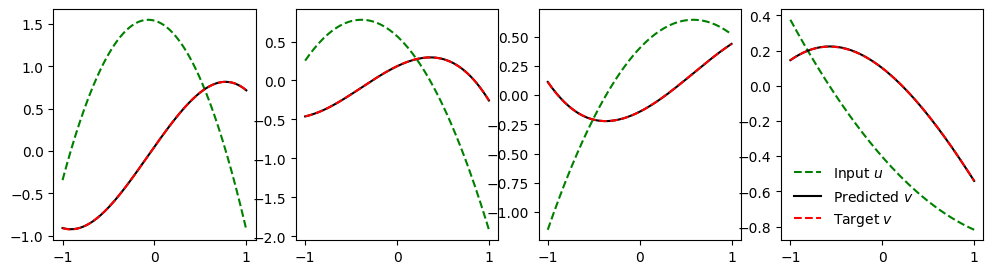

In [8]:
fig, axs = plt.subplots(1, num_functions, figsize=(12, 3))

# Equidistant grid
y = torch.linspace(-1, 1, 128)

# Call operator for polynomials
for i in range(num_functions):
    u = polynomial(a[i])
    v_exact = integral(a[i])(y)
    v_pred = operator(x.unsqueeze(0), u(x).unsqueeze(0), y.reshape(1, -1, 1)).squeeze(0)

    # Unify integral to zero mean
    v_pred -= v_pred.mean()
    v_exact -= v_exact.mean()

    # Plot functions
    v_pred = v_pred.reshape(y.shape).detach()
    axs[i].plot(y, u(y), "g--", label="Input $u$")
    axs[i].plot(y, v_pred, "k-", label="Predicted $v$")
    axs[i].plot(y, v_exact, "r--", label="Target $v$")
plt.legend()
plt.show()